In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import tensorflow as tf
# from keras import layers


from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image

import tensorflow.keras.backend as K


from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random



In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("Not enough GPU hardware devices available")
else:
    config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


2023-06-10 16:56:18.640933: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-06-10 16:56:18.679711: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-10 16:56:18.680095: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 with Max-Q Design computeCapability: 7.5
coreClock: 1.23GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 357.69GiB/s
2023-06-10 16:56:18.680276: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-06-10 16:56:18.681581: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-10 16:56:18.682802: I tensorflow/st

In [3]:
# tf.debugging.set_log_device_placement(True)       # Will print the log information of every execution of tensorflow, mainly about 

In [4]:
#Size of our input images
# SIZE = 128        # It was this value at the beginning, but the image display was poor. 
SIZE = 224
# SIZE = 228          # It was 224, but in order for the current autoencoder model configuration work adequately, we changed it 228

# Setting the training and testing datasets 

ImageDataGenerator.flow_from_directory: Takes the path to a directory and generates batches of augmented data.

In [5]:
# batch_size = 64
batch_size = 32
datagen = ImageDataGenerator(rescale=1./255) # Typically used for data augmentation. Here it is only rescaling the image pixels value to range 0 to 1 in decimals

train_generator = datagen.flow_from_directory(
    "../../Images/june5Night/Positive/",         # For home laptop
    # "../../../BottleStoodUp_atNight/Positive/",          # For work laptop
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'          # Class used for working with Autoencoders
    
    )

Found 295 images belonging to 1 classes.


In [6]:
validation_generator = datagen.flow_from_directory(
    "../../Images/june5Night/Positive_val/",     # For home laptop
    # "../../../BottleStoodUp_atNight/Positive_val/",           # For work lpatop   
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    )


Found 20 images belonging to 1 classes.


In [7]:
anomaly_generator = datagen.flow_from_directory(
    "../../Images/june5Night/Anomalies2.0/",         # For home laptop
    # "../../../BottleStoodUp_atNight/Anomalies2.0/",           # For work lpatpo
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    )


Found 10 images belonging to 1 classes.


In [8]:
test_set_generator = datagen.flow_from_directory(
    "../../Images/june5Night/Evaluation/",       # For home laptop
    # "../../../BottleStoodUp_atNight/Evaluation/",             # For work laptop  
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='binary'
    )


Found 30 images belonging to 2 classes.


# Showing one sample of the training set images

Grabbing only one image of one batch of the training set.

In [9]:
images_in_batch = next(train_generator)[0]
print(type(images_in_batch))
print(len(images_in_batch))
print(tf.reduce_min(images_in_batch), tf.reduce_max(images_in_batch))

<class 'numpy.ndarray'>
32


2023-06-10 16:56:19.185684: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-06-10 16:56:19.207802: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2599990000 Hz
2023-06-10 16:56:19.208339: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd34c001260 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-06-10 16:56:19.208382: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-06-10 16:56:19.273659: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-10 16:56:19.274141: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x45023b0 initialized for platform CUDA (this does not guarantee that XLA will

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


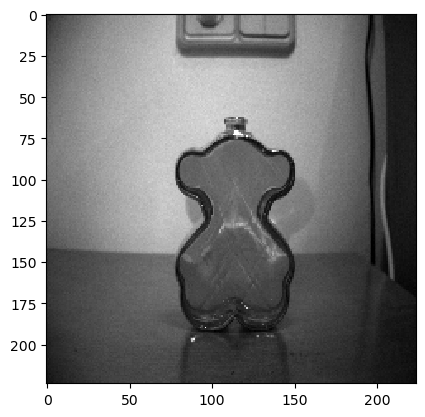

In [10]:
single_img = images_in_batch[0]
plt.imshow(single_img)

# Configuring the Autoencoder netwrok

In [11]:
latent_dim = 98  # Number of latent dimension parameters

input_img = Input(shape=(SIZE, SIZE, 3))
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D( (2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D( (2, 2), padding='same')(x)

x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D( (2, 2), padding='same')(x)
x = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

shape_before_flattening = K.int_shape(x)
print(shape_before_flattening)
x = Flatten()(x)
x = Dense(196, activation='relu')(x)        # Activation function is supposed to be none, i.e the output is the same as the input

Z = Dense(latent_dim)(x)
print(K.int_shape(Z))

encoder = Model(input_img,Z)
encoder.summary()

(None, 14, 14, 1)
(None, 98)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (No

In [12]:
# decoder takes the latent distribution sample as input
decoder_input = Input(K.int_shape(Z)[1:])
x = Dense(14*14*4, activation='relu', name="intermediate_decoder", input_shape=(latent_dim,))(decoder_input)
# Expand to 784 total pixels
x = Dense(784, activation='sigmoid', name="original_decoder")(x)
x = Reshape((14,14,4),input_shape=(784,))(x)

x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)
x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)
x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)
x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(Z)

decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 98)]              0         
_________________________________________________________________
intermediate_decoder (Dense) (None, 784)               77616     
_________________________________________________________________
original_decoder (Dense)     (None, 784)               615440    
_________________________________________________________________
reshape (Reshape)            (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 3)         111       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 3)         84  

In [13]:
# VAE model statement
ae = Model(input_img,z_decoded)
ae.compile(optimizer='adam', loss='mean_squared_error')

ae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 16)        0   

These are the weights of a specific layer of the encoder model, before training are:

In [14]:
layer_number = 1
print("quantity of layers in the model: ", len(encoder.layers))
print("The weigths in the", encoder.layers[layer_number].name, "is: ", encoder.layers[layer_number].weights)

quantity of layers in the model:  13
The weigths in the conv2d is:  [<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
array([[[[ 0.07135341, -0.05398591,  0.09496981, ...,  0.04733343,
           0.0152268 , -0.02198264],
         [-0.01067767,  0.09968038,  0.04578115, ..., -0.0872425 ,
          -0.06561792,  0.02468219],
         [-0.02299977, -0.02643693, -0.03235104, ..., -0.06102709,
           0.05412576,  0.02597351]],

        [[-0.06385317, -0.04789232, -0.09435175, ...,  0.03228697,
          -0.08156003, -0.04392024],
         [ 0.09391783,  0.00674081,  0.03313248, ..., -0.07020335,
          -0.08101222,  0.05594878],
         [-0.02986958, -0.05075842, -0.02162134, ..., -0.03557117,
          -0.03363596,  0.06874767]],

        [[-0.07492733,  0.0612181 ,  0.06964859, ...,  0.01968806,
          -0.0108427 , -0.07712757],
         [-0.04667294, -0.04820855,  0.05547494, ...,  0.04615879,
           0.05152676, -0.06135617],
         [ 0.02970265,

These are the weights of a specific layer of the decoder model,before training are:

In [15]:
# layer_number = 1
# print("quantity of layers in the model: ", len(decoder.layers))
# print("The weigths in the", decoder.layers[layer_number].name, "is: ", decoder.layers[layer_number].weights)

These are the weights of a specific layer of the autoencoder model,before training are:

In [16]:
# layer_number = 1
# print("quantity of layers in the model: ", len(ae.layers))
# print("The weigths in the", ae.layers[layer_number].name, "is: ", ae.layers[layer_number].weights)

In [17]:
# from tensorflow.keras.callbacks import EarlyStopping
# # run the model
# # early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=5, mode='auto')
# history = ae.fit(train_generator, epochs=400, validation_data=validation_generator, verbose=1, shuffle = True)

In [18]:

# # Get the training and validation loss values from the history object
# train_loss = history.history['loss']
# val_loss = history.history['val_loss']

# # Plot the training and validation loss
# epochs = range(1, len(train_loss) + 1)
# plt.plot(epochs, train_loss, 'b-', label='Training Loss')
# plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


In [19]:
model_version = 'UsingValidDS1_1'
print(model_version)

UsingValidDS1_1


In [20]:
# ae.save(f"../../BottlesAnomalies_TFM/models/{model_version}")

In [21]:
print(type(ae))

<class 'tensorflow.python.keras.engine.training.Model'>


Loading the model that was previously saved


In [22]:
model = keras.models.load_model('../models/UsingValidDS1_1')
print(type(model))

<class 'tensorflow.python.keras.engine.training.Model'>


## See the weights after the model loading

These are the weights of a specific layer of the encoder model, AFTER training:

In [23]:
layer_number = 1
print("quantity of layers in the model: ", len(encoder.layers))
print("The weigths in the", encoder.layers[layer_number].name, "is: ", encoder.layers[layer_number].weights)

quantity of layers in the model:  13
The weigths in the conv2d is:  [<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
array([[[[ 0.07135341, -0.05398591,  0.09496981, ...,  0.04733343,
           0.0152268 , -0.02198264],
         [-0.01067767,  0.09968038,  0.04578115, ..., -0.0872425 ,
          -0.06561792,  0.02468219],
         [-0.02299977, -0.02643693, -0.03235104, ..., -0.06102709,
           0.05412576,  0.02597351]],

        [[-0.06385317, -0.04789232, -0.09435175, ...,  0.03228697,
          -0.08156003, -0.04392024],
         [ 0.09391783,  0.00674081,  0.03313248, ..., -0.07020335,
          -0.08101222,  0.05594878],
         [-0.02986958, -0.05075842, -0.02162134, ..., -0.03557117,
          -0.03363596,  0.06874767]],

        [[-0.07492733,  0.0612181 ,  0.06964859, ...,  0.01968806,
          -0.0108427 , -0.07712757],
         [-0.04667294, -0.04820855,  0.05547494, ...,  0.04615879,
           0.05152676, -0.06135617],
         [ 0.02970265,

These are the weights of a specific layer of the Autoencoder model, AFTER training:

In [24]:
layer_number = 1
print("quantity of layers in the model: ", len(model.layers))
print("The weigths in the", model.layers[layer_number].name, "is: ", model.layers[layer_number].weights)

quantity of layers in the model:  14
The weigths in the conv2d is:  [<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
array([[[[ 0.04215294, -0.05336958,  0.08855855, ..., -0.09547437,
           0.11762514,  0.01967275],
         [ 0.02281356,  0.01539198, -0.06676454, ..., -0.03695678,
          -0.04258858,  0.07786176],
         [ 0.07834383, -0.07231868, -0.01419686, ..., -0.01463854,
           0.01037634, -0.00226862]],

        [[-0.0582457 , -0.10062331,  0.01796589, ..., -0.01516763,
          -0.08339964, -0.01274647],
         [-0.02184502, -0.11595834, -0.05565513, ..., -0.03363729,
          -0.08707915, -0.06118062],
         [ 0.03551131, -0.09673581, -0.03370395, ...,  0.07382822,
          -0.05038366,  0.00821096]],

        [[-0.03919005, -0.04528062,  0.04654642, ..., -0.07606678,
          -0.0844703 ,  0.08766729],
         [-0.0421984 ,  0.06734621,  0.07157017, ...,  0.05678615,
          -0.01006458, -0.03776624],
         [ 0.0979948 ,

Indeed the weights of the "Autoencoder" model have been updated but the ones from the "Encoder" have not. This is expected, since the model that was trained was actually the "Autoencoder" mdoel.

## Perform an Autoencoder reconstruction in one image

Get all batches generated by the datagen and pick a batch for prediction

In [25]:
#Just to test the model. 
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
# while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
while img_num < len(train_generator):        #I think this should be the correct while clause
    data = train_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1
    
print("number of batches are: ", img_num)


number of batches are:  10


In [26]:
print(len(data_batch))

10


Predict on the first batch of images. Do also notice that the prediction is being carried out over the images we used for training.

In [27]:
print(data_batch[0].shape)
predicted = model.predict(data_batch[0])  
print(predicted.shape)

(32, 224, 224, 3)


2023-06-10 16:56:23.141149: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-10 16:56:23.355099: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


(32, 224, 224, 3)


The above is 15 length because it corresponds to the 15 predicted images of a batch. Recall that the predictions are reconstructions of the input images, since we are working with the autoencoder network.

In [28]:
single_img = data_batch[0][0]

In [29]:
print(single_img.shape)

(224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


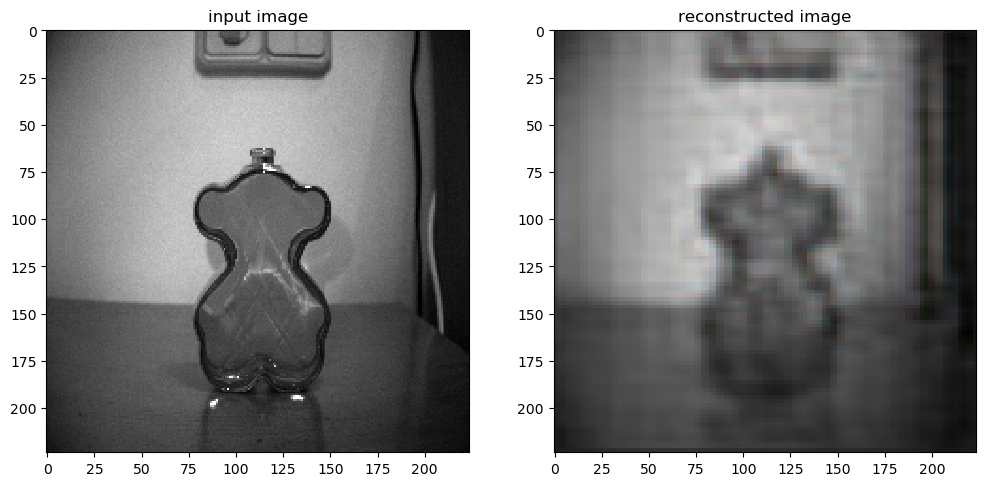

In [30]:
#Sanity check, view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0]-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("input image")
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.title("reconstructed image")
plt.imshow(predicted[image_number])
plt.show()

# Quantifying the reconstruction error using "evaluate_generator()" function

Let us examine the reconstruction error of our validation data (good/normal images) and the anomaly images

In [31]:
validation_error = model.evaluate_generator(validation_generator)
print("Recon. error for the validation (normal) data is: ", validation_error)

Instructions for updating:
Please use Model.evaluate, which supports generators.
Recon. error for the validation (normal) data is:  0.0030412543565034866


This reconstruction error above should be very low, since the validation generator is full of normal images (good images)

Whereas the reconstruction error here below, for the "anomaly_generator" should be higher, since this dataset is comprised of full anomaly images.

In [32]:
anomaly_error = model.evaluate_generator(anomaly_generator)
print("Recon. error for the anomaly data is: ", anomaly_error)

Recon. error for the anomaly data is:  0.0033929753117263317


See that this error is slightly higher than the error in the validation dataset. This is good, but the difference is not that significant and this could result in wrong anomaly detections. Let's see some detections.

SIDENOTE: Additionally, we can check the train generator error according to the "evaluate_generator()" function.

In [33]:
training_error = model.evaluate_generator(train_generator)
print("Recon. error for the training (non-anomaly) data is: ", training_error)

Recon. error for the training (non-anomaly) data is:  0.0031672618351876736


See that the above value does not correspond with the below mean reconstruction error of the training set that will be computed. It should at least be close, I think. This is something to check.

Also see tha the error from the anomaly images is smaller than the error of the training set, which consists of non-anomaly images. THis is not expected and means that this particular model is shit.

# Computing the reconstruction error without using the "evaluate_generator()" function

The following function computes the reconstrution error per each batch of images. It does, for each of the batches:
- Initialize a vector for storing the reconstruction errors.
- A for loop that traverses all the images contained in a batch.
    - Take the one image of the batch.
    - Add a new size dimension to the image.
    - Make a prediction of the selected image with the model that was built.
    - Evaluate the performance of the prediction, i.e. compute the prediction error.
    - Append the reconstruction error into a list.
- Compute the mean and std deviation of the error.
 

In [34]:
def calc_recon_error(batch_images):   
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]):
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        reconstruction = model.predict([[img]])
        # reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]    # The batch_size parameter for the moment can be supressed. Results were seen to be the same
        # reconstruction_error = model.evaluate([reconstruction],[[img]])[0]                    # It included the [0] subscription but with this new model, the rec error is directly a float value, so no more need for subscription
        reconstruction_error = model.evaluate([reconstruction],[[img]])
        recon_error_list.append(reconstruction_error)   
    return recon_error_list

In [35]:
total_rec_error = []
for i in range(len(train_generator)):        #I think this should be the correct while clause
    data = train_generator.next()
    total_rec_error.append(calc_recon_error(data[0]))
    
print("The list of rec. error contains ", len(total_rec_error), "batches of rec. errors")

1/1 [==============================] - 0s 624us/step - loss: 0.0047
The list of rec. error contains  10 batches of rec. errors


In [36]:
total_rec_error_list = [item for sublist in total_rec_error for item in sublist]
print(len(total_rec_error_list))

295


In [37]:
na_average_recon_error = np.mean(np.array(total_rec_error_list))  
na_stdev_recon_error = np.std(np.array(total_rec_error_list)) 
min_prob = np.min(total_rec_error_list)
max_prob = np.max(total_rec_error_list)
print("THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES\n")
print("The average of the errors list is: ", na_average_recon_error)
print("The standard deviation of the errors list is: ", na_stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES

The average of the errors list is:  0.004846893152285178
The standard deviation of the errors list is:  0.0014679818360787832
The min value of the errors list is:  0.0025862266775220633
The max value of the errors list is:  0.01348365843296051


Compute the average and std dev. of recon. error for positive (anomalies) samples. 


In [38]:
anomaly_batch = anomaly_generator.next()

In [39]:
total_rec_error_anomalies = []
for i in range(len(anomaly_generator)):        #I think this should be the correct while clause
    data = anomaly_generator.next()
    total_rec_error_anomalies.append(calc_recon_error(data[0]))
    
print("The list of rec. error for anomalies contains ", len(total_rec_error_anomalies), "batches of rec. errors")

1/1 [==============================] - 0s 721us/step - loss: 0.0071
The list of rec. error for anomalies contains  1 batches of rec. errors


In [40]:
total_rec_error_anomalies = [item for sublist in total_rec_error_anomalies for item in sublist]
print(len(total_rec_error_anomalies))

10


In [41]:
a_average_recon_error = np.mean(np.array(total_rec_error_anomalies))  
a_stdev_recon_error = np.std(np.array(total_rec_error_anomalies)) 
min_prob = np.min(total_rec_error_anomalies)
max_prob = np.max(total_rec_error_anomalies)
print("THIS IS FOR THE ANOMALY IMAGES\n")
print("The average of the errors list is: ", a_average_recon_error)
print("The standard deviation of the errors list is: ", a_stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE ANOMALY IMAGES

The average of the errors list is:  0.005826009251177311
The standard deviation of the errors list is:  0.0029321285761962335
The min value of the errors list is:  0.0036630856338888407
The max value of the errors list is:  0.014026803895831108


Compute the average and std dev. of recon. error for the validation (non-anomalies) samples. 


In [42]:
total_rec_error_validation = []
for i in range(len(validation_generator)):        #I think this should be the correct while clause
    data = validation_generator.next()
    total_rec_error_validation.append(calc_recon_error(data[0]))
    
print("The list of rec. error for anomalies contains ", len(total_rec_error_validation), "batches of rec. errors")

1/1 [==============================] - 0s 754us/step - loss: 0.0052
The list of rec. error for anomalies contains  1 batches of rec. errors


In [43]:
total_rec_error_validation = [item for sublist in total_rec_error_validation for item in sublist]
print(len(total_rec_error_validation))

20


In [44]:
val_average_recon_error = np.mean(np.array(total_rec_error_validation))  
val_stdev_recon_error = np.std(np.array(total_rec_error_validation)) 
min_prob = np.min(total_rec_error_validation)
max_prob = np.max(total_rec_error_validation)
print("THIS IS FOR THE VALIDATION IMAGES\n")
print("The average of the errors list is: ", val_average_recon_error)
print("The standard deviation of the errors list is: ", val_stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE VALIDATION IMAGES

The average of the errors list is:  0.004317435901612043
The standard deviation of the errors list is:  0.001611785837103968
The min value of the errors list is:  0.0025878085289150476
The max value of the errors list is:  0.01035284623503685


Below, we can see the plot of the reconstruction error values, of the non-anomaly list (blue) and the anomaly list (red).

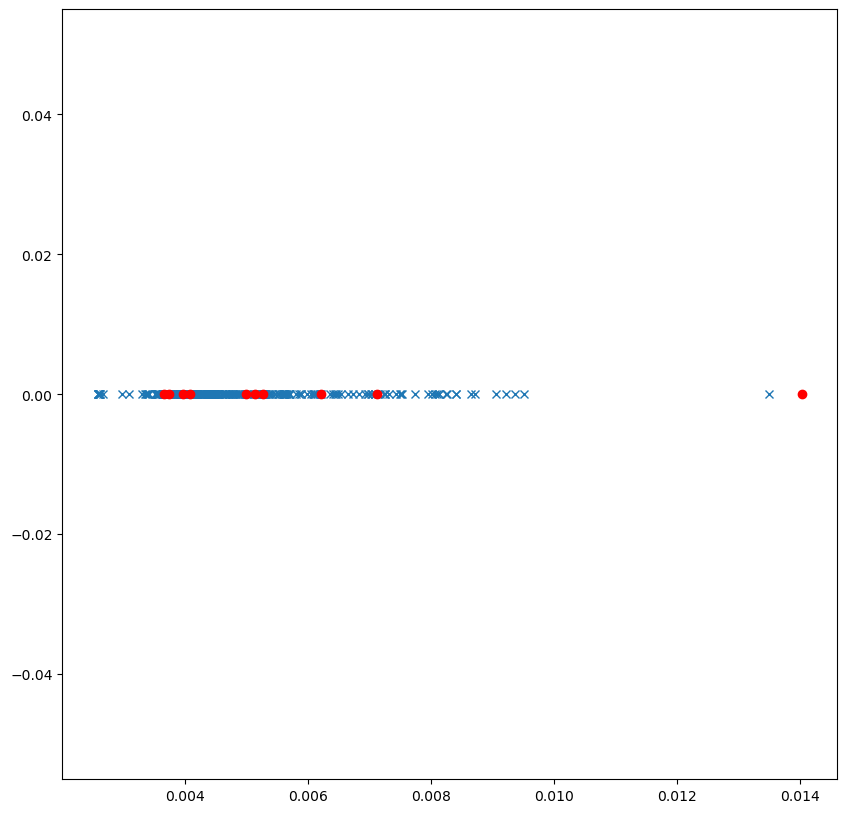

In [45]:
plt.figure(figsize=(10, 10))
val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(total_rec_error_list, np.zeros_like(total_rec_error_list) + val, 'x')
plt.plot(total_rec_error_anomalies, np.zeros_like(total_rec_error_anomalies) + val, 'ro')
plt.show()

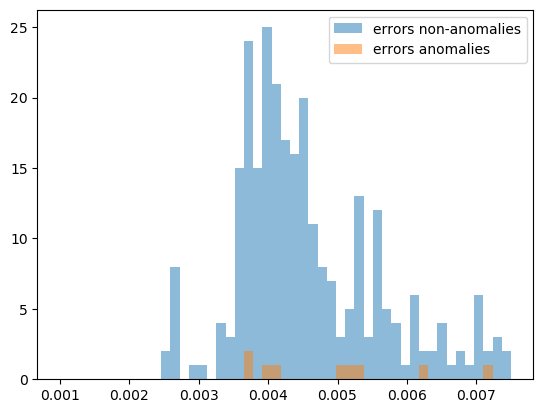

In [46]:
import random
import numpy
from matplotlib import pyplot

bins = numpy.linspace(0.001, 0.0075, 50)

pyplot.hist(total_rec_error_list, bins, alpha=0.5, label='errors non-anomalies')
pyplot.hist(total_rec_error_anomalies, bins, alpha=0.5, label='errors anomalies')
pyplot.legend(loc='upper right')
pyplot.show()

## Checking the latent space

Let's update the weights of the encoder model.

In [47]:
# Copy the layer weights from the base model to the target model
for i, target_layer in enumerate(encoder.layers):
    base_layer = model.layers[i]
    target_layer.set_weights(base_layer.get_weights())

# Verify if the weights are successfully copied
for base_layer, target_layer in zip(model.layers[:len(encoder.layers)], encoder.layers):
    base_weights = base_layer.get_weights()
    target_weights = target_layer.get_weights()
    for base_weight, target_weight in zip(base_weights, target_weights):
        if (base_weight == target_weight).all():
            print("Layer weights are successfully copied.")
        else:
            print("Error: Layer weights are not copied correctly.")


Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.


In [48]:
########################################################
# Calculate KDE using sklearn
from sklearn.neighbors import KernelDensity

#Get encoded output of input images = Latent space
encoded_images = encoder.predict_generator(train_generator)

Instructions for updating:
Please use Model.predict, which supports generators.


In [49]:
print(encoded_images.shape)

(295, 98)


See that it is 179 length because it corresponds to all the images that belong to the training dataset. The second length corresponds to the output shape of the model as specified in its structure at the beginning.

In [50]:
type(encoded_images)

numpy.ndarray

In [51]:
encoder_output_shape = encoder.output_shape 
print(encoder_output_shape)

(None, 98)


Now, let's fit KDE to the image latent data

In [52]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images)

The above function fits a kernel density estimation to the data that is provided, that is, the "encoded_images" variable. It does so using a Guassian kernel of bandwidth 0.2.

The badnwidth parameter affects on how the selected kernel will fit each sample of the given data. For example for the case in which the kernel is a Gaussian distribution, the bandwidth parameter would affect in how thin or wide is the Gaussian distribution.

At this point in the variable "kde" we have some numbers that are the result of fitting Gaussian functions to the given data points in the variable "encoded_images". We will use the "kde" variable later for scoring with it, some given data points; the scoring will be given depending on how similar are the given data points to the ones that it had estimated.

Here below, it is shown the kde values corresponding to each encoded sample. THese are supposed to be very close to each other in value.

In [53]:
density_vals = kde.score_samples(encoded_images)
print(density_vals)

[64.72099839 64.68196719 64.33937267 64.27565128 64.53620553 65.13260556
 65.14686852 65.17386312 65.16904812 65.23908184 65.23189068 65.3111
 65.24045996 64.87187421 64.90469312 65.24165326 65.24319784 65.25794691
 65.30041221 65.15769339 65.27154593 65.07702025 64.99204632 65.04429162
 64.92452005 65.06369961 65.13845247 65.16763948 65.00265178 65.07525217
 65.02244735 65.06297403 64.9539388  63.97122537 63.96584513 63.9909313
 64.18623458 64.2986697  64.84235346 65.04850767 65.14728851 63.0806254
 63.20942369 63.11621121 63.09423785 63.27430931 63.57130985 63.55284258
 63.59569796 65.2371372  65.07897113 65.14463045 65.19215309 65.21471694
 65.28452384 65.27392069 65.22826746 65.24219946 65.23411031 65.03320594
 64.92897187 65.13689468 65.32849792 65.38473329 65.233617   65.2484847
 64.89319626 64.75562064 64.43224597 64.78248818 64.85265271 64.77419887
 64.79651798 64.89227003 65.03412801 65.04593618 65.08673061 65.0170246
 64.66269506 65.24711098 65.20014895 65.21075945 65.1995655

From here, the mean and standard deviation of these values are computed

In [54]:
average_density = np.mean(density_vals)
stdev_density = np.std(density_vals)
print("The avg of the density values is: ", average_density)
print("The stdev_density of the density values is: ", stdev_density)

The avg of the density values is:  64.49789934789545
The stdev_density of the density values is:  0.5951278115068096


based on the above data create a function that outputs a probability of a KDE value to be considered an anomaly or non-anomaly image

In [55]:
def ranges_mapper(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

In [56]:
# def map_kde2prob_list(input_list):
#     threshold = average_density          # The mean of the kde corresponding to the non-anomaly images
#     std_dev = stdev_density            # The std deviation of the kde corresponding to the non-anomaly images
#     prob_score_list = []
#     prob_score = 0              # This was changed for making threshold+std_dev be mapped to be 50% chance. Before it was directly mapped threshold value to 50% chance
#     for i in range (len(input_list)):
#         aux_score = input_list[i] - threshold
#         if aux_score>=0:
#             additional = ranges_mapper(aux_score, 0, std_dev, 0, 50)
#             prob_score_tot = prob_score+additional
#         else:
#             additional = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
#             prob_score_tot = prob_score-additional
#         if prob_score_tot > 100:
#             prob_score_tot = 100
#         if prob_score_tot < 0:
#             prob_score_tot = 0
#         prob_score_list.append(prob_score_tot)
#     return prob_score_list

In [57]:
# def map_kde2prob(value):
#     threshold = average_density         # The mean of the kde corresponding to the non-anomaly images
#     std_dev = stdev_density          # The std deviation of the kde corresponding to the non-anomaly images
#     prob_score = 0              # This was changed for making threshold+std_dev be mapped to be 50% chance. Before it was directly mapped threshold value to 50% chance
#     aux_score = value - threshold
#     print("value is: ", value)
#     print("aux_score is: ", aux_score)
        
#     if aux_score>=0:
#         additional = ranges_mapper(aux_score, 0, std_dev, 0, 50)
#         print("additional is: ", additional)
#         prob_score_tot = prob_score+additional
#         print("prob_score_tot is: ", prob_score_tot)
        
#     else:
#         additional = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
#         prob_score_tot = prob_score-additional
#     if prob_score_tot > 100:
#         prob_score_tot = 100
#     if prob_score_tot < 0:
#         prob_score_tot = 0    
#     return prob_score_tot

In [58]:
def map_kde2prob_list(input_list):
    threshold = average_density          # The mean of the kde corresponding to the non-anomaly images
    std_dev = stdev_density            # The std deviation of the kde corresponding to the non-anomaly images
    prob_score_list =[]
    for i in range (len(input_list)):
        aux_score = input_list[i] - threshold
        prob_score = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
        if prob_score<0:
            prob_score = 0
        if prob_score>100:
            prob_score = 100     
        prob_score_list.append(prob_score)
    return prob_score_list

In [59]:
def map_kde2prob(value):
    threshold = average_density         # The mean of the kde corresponding to the non-anomaly images
    std_dev = stdev_density          # The std deviation of the kde corresponding to the non-anomaly images
    
    aux_score = value - threshold
    prob_score = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
    if prob_score<0:
            prob_score = 0
    if prob_score>100:
        prob_score = 100 
    return prob_score

In [60]:
def computePred(kde_value):
    pred = 0
    prob_anomaly = map_kde2prob(kde_value)/100
    if prob_anomaly > 0.5:
        pred = 1
    return pred

In [61]:
print(map_kde2prob_list([average_density - 1*stdev_density]))

[49.99999999999973]


In [62]:
#Get encoded output of input images = Latent space
encoded_images_test_set = encoder.predict_generator(test_set_generator)

In [63]:
print(encoded_images_test_set.shape)

(30, 98)


In [64]:
density_vals_test = kde.score_samples(encoded_images_test_set)
print(density_vals_test)

[64.28233384 65.09165355 65.04551636 65.09727923 65.28013308 65.13215993
 64.54431905 64.75808718 64.59698114 64.03363134 59.42041029 63.79099388
 64.0832379  64.4048126  64.73228117 64.56879944 63.73528201 63.89429637
 63.68845171 63.76793228 61.13693099 59.28148703 62.87303678 63.58323855
 62.10354965 63.79174412 63.75796596 63.77219433 59.66161832 60.11585202]


In [65]:
average_density + stdev_density

65.09302715940227

In [66]:
average_density - stdev_density

63.90277153638865

In [67]:
prob_test = map_kde2prob_list(density_vals_test)
print(prob_test)

[18.110858505656115, 49.884595035343835, 46.008353395978546, 50.357239911811966, 65.71980990163618, 53.287761843274716, 3.899977526268362, 21.85982800093917, 8.32441297865332, 39.00573954753708, 100, 59.39106281402196, 34.83801600968742, 7.8207358319586096, 19.691721846641027, 5.9567117255157935, 64.0717277227673, 50.712045824373256, 68.00620126233763, 61.32859634763229, 100, 100, 100, 76.84574452607455, 100, 59.32803146403166, 62.16592269533414, 60.97051785075055, 100, 100]


See the final predictions based on the KDE average values that was computed before.

In [68]:
ground_truth = []
for i in range(len(test_set_generator)):        #I think this should be the correct while clause
    _, labels = test_set_generator.next()
    ground_truth.append(labels)
    
print("The list of rec. error for anomalies contains ", len(ground_truth), "batches of rec. errors")

The list of rec. error for anomalies contains  1 batches of rec. errors


In [69]:
ground_truth = [item for sublist in ground_truth for item in sublist]
ground_truth = [int(x) for x in ground_truth]


In [70]:
pred_list =[]
for i in range(len(prob_test)):
    
    if(prob_test[i]>50):
        pred = 1
    else:
        pred = 0
    pred_list.append(pred)
print(ground_truth)
print(pred_list)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [71]:
from sklearn import metrics
print('AUC = ', metrics.roc_auc_score(ground_truth, prob_test))

AUC =  0.905


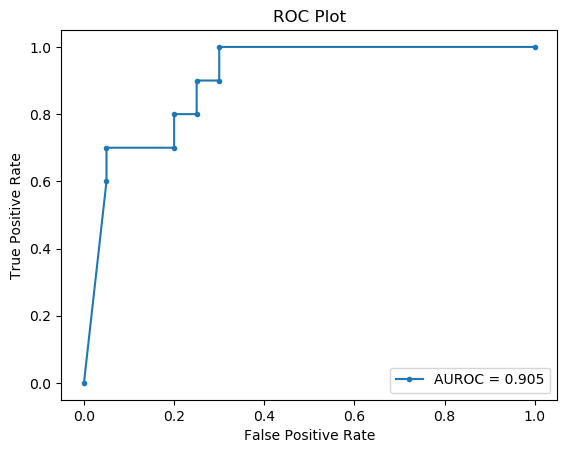

In [72]:
fpr, tpr, thresholds = metrics.roc_curve(ground_truth, prob_test)
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % metrics.roc_auc_score(ground_truth, prob_test))
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [73]:
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

The fpr is:  [0.   0.05 0.05 0.2  0.2  0.25 0.25 0.3  0.3  1.  ]
The tpr is:  [0.  0.6 0.7 0.7 0.8 0.8 0.9 0.9 1.  1. ]
The thresholds are:  [101.         100.          76.84574453  64.07172772  62.1659227
  61.32859635  60.97051785  59.39106281  59.32803146   3.89997753]


FRom above we can see that the results are not that good; these could be improved. HOwever these results are not as bad as the previous programs. 

FRom the above graph, it is seen that the best threshold could be:  59.32803146. Let's see if we obtain what we expect (FPR = 0.3 and TPR = 1.0).

- NOTE: Notice, that it was previously accorded that the thresholds shown by the metrics.roc_auc_score(ground_truth, prob_test) functions were going to be considered as 100-x to effectively test the FPR and TPR values. However in this case, strangely, see that directly using the threshold displayed by the function is used. It is not known yet why this happens. 

In [74]:
def pred_label_onProb(probs_list, prob_threshold):
    pred_based_onProb = []
    for i in range (len(probs_list)):
        if probs_list[i] > prob_threshold:
            prediction = 1                          ## Stands for classifiaction of anomaly bottle
        else:
            prediction = 0
        pred_based_onProb.append(prediction)
    return pred_based_onProb

In [75]:
# from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, SpecificityAtSensitivity
from sklearn.metrics import confusion_matrix

In [85]:
conf_matrix = confusion_matrix(ground_truth, pred_label_onProb(prob_test, ( 59.32803146  )))
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)
print("Using the threshold = 59.32803146 ")

[[14  6]
 [ 0 10]]
The FPR values are:  0.3
The TPR values are:  1.0
Using the threshold = 59.32803146 


## Trehshold based on Gaussian distribution of the non-anomaly images

In [78]:
def map_error2prob(value):
    # Calculate the mean and standard deviation
    mean = na_average_recon_error
    std_dev = na_stdev_recon_error
    aux_score = value - mean
    prob_score = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
    if prob_score<0:
        prob_score = 0
    if prob_score>100:
        prob_score = 100
    return prob_score

See below test, that shows if a reconstruction error is equal to the mean of the reconstruction error plus its standard deviation has 50% chance of being predicted as anomaly image.

In [79]:
print(map_error2prob(na_average_recon_error + na_stdev_recon_error))

50.000000000000014


In [80]:
def map_error2prob_list(input_list):
    # Calculate the mean and standard deviation
    mean = na_average_recon_error
    std_dev = na_stdev_recon_error
    prob_score_list = []
    for i in range (len(input_list)):
        aux_score = input_list[i] - mean
        prob_score = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
        if prob_score<0:
            prob_score = 0
        if prob_score>100:
            prob_score = 100
        prob_score_list.append(prob_score)
    return prob_score_list

In [81]:
def computePred(err_value):
    pred = 0
    prob_anomaly = map_error2prob(err_value)/100
    if prob_anomaly > 0.5:
        pred = 1
    else:
        pred =0 
    return pred

In [82]:
y_pred_final = []
y_true_final = []
y_prob_final = []
for i in range(len(test_set_generator)):        # Traversing all the batches of the test set
    batch_images, labels = next(test_set_generator)
    y_pred = []
    y_true = []
    y_prob = []
    for im in range(0, batch_images.shape[0]):  #Traversing all the images in the batch
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]])
        probability = map_error2prob(reconstruction_error)
        prediction = computePred(reconstruction_error)   
        y_pred.append(prediction) # Save Prediction
        y_true.append(labels[im]) # Save Truth  
        y_prob.append(probability) # Save probability  
    y_pred_final.append(y_pred)  
    y_true_final.append(y_true)  
    y_prob_final.append(y_prob)  
print(y_true_final)
print(y_pred_final)
print(y_prob_final)
 

1/1 [==============================] - 0s 844us/step - loss: 0.0065
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
[[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]]
[[31.645625400498123, 4.01464613357942, 11.95668013140211, 18.279893430352857, 24.63264157533283, 26.396688596353385, 6.92638834049502, 48.32230159649064, 100, 100, 100, 57.93196606248657, 66.55865433515052, 11.93817081783527, 4.022345242413504, 17.632108316705636, 48.94915986564419, 74.2413926165035, 29.171816783833986, 30.762777139083408, 39.44741209308108, 13.917088030646257, 16.61762384305844, 1.3177491178564118, 23.05701841478703, 89.98876487032958, 26.08019043677646, 37.628138482652, 0.5794701736325623, 56.358880597031344]]


In [83]:
y_true_final = [item for sublist in y_true_final for item in sublist]
y_true_final = [int(i) for i in y_true_final]
y_pred_final = [item for sublist in y_pred_final for item in sublist]
y_prob_final = [item for sublist in y_prob_final for item in sublist]
print(y_true_final)
print(y_pred_final)
print(y_prob_final)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
[31.645625400498123, 4.01464613357942, 11.95668013140211, 18.279893430352857, 24.63264157533283, 26.396688596353385, 6.92638834049502, 48.32230159649064, 100, 100, 100, 57.93196606248657, 66.55865433515052, 11.93817081783527, 4.022345242413504, 17.632108316705636, 48.94915986564419, 74.2413926165035, 29.171816783833986, 30.762777139083408, 39.44741209308108, 13.917088030646257, 16.61762384305844, 1.3177491178564118, 23.05701841478703, 89.98876487032958, 26.08019043677646, 37.628138482652, 0.5794701736325623, 56.358880597031344]


Above we see the predictions based on a threshold of 50%. See that the results are not that good. There are some false positive results and more important there are a considerable number of false negatives.

AUC =  0.4


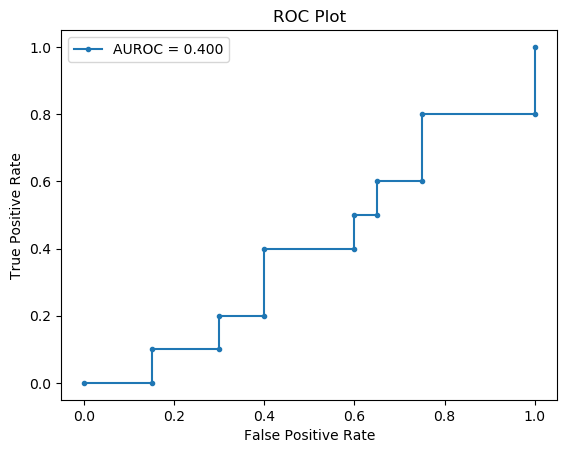

The fpr is:  [0.   0.15 0.15 0.3  0.3  0.4  0.4  0.6  0.6  0.65 0.65 0.75 0.75 1.
 1.  ]
The tpr is:  [0.  0.  0.1 0.1 0.2 0.2 0.4 0.4 0.5 0.5 0.6 0.6 0.8 0.8 1. ]
The thresholds are:  [101.         100.          89.98876487  57.93196606  56.3588806
  48.3223016   37.62813848  26.3966886   26.08019044  24.63264158
  23.05701841  17.63210832  13.91708803   4.01464613   0.57947017]


In [84]:
print('AUC = ', metrics.roc_auc_score(y_true_final, y_prob_final))
fpr, tpr, thresholds = metrics.roc_curve(y_true_final, y_prob_final)
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % metrics.roc_auc_score(y_true_final, y_prob_final))
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

At this point, the graph above shows us that there is not any acceptable threshold to work with. The result from the reconstruction error are poor in this approach.

## Verifying the evaluation set

In [101]:
#Just to test the model. 
data_batch_test = []  #Capture all training batches as a numpy array
labels_test = []
img_num = 0
# while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
while img_num < len(test_set_generator):        #I think this should be the correct while clause
    data, labels = test_set_generator.next()
    data_batch_test.append(data)
    labels_test.append(labels)
    img_num = img_num + 1
    
print("number of batches are: ", img_num)

number of batches are:  1


In [102]:
print(data_batch_test[0].shape)
predicted_fromTestSet = model.predict(data_batch_test[0])  
print(predicted_fromTestSet.shape)

(30, 224, 224, 3)
(30, 224, 224, 3)


In [103]:
single_img = data_batch_test[0][0]
print(single_img.shape)

(224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


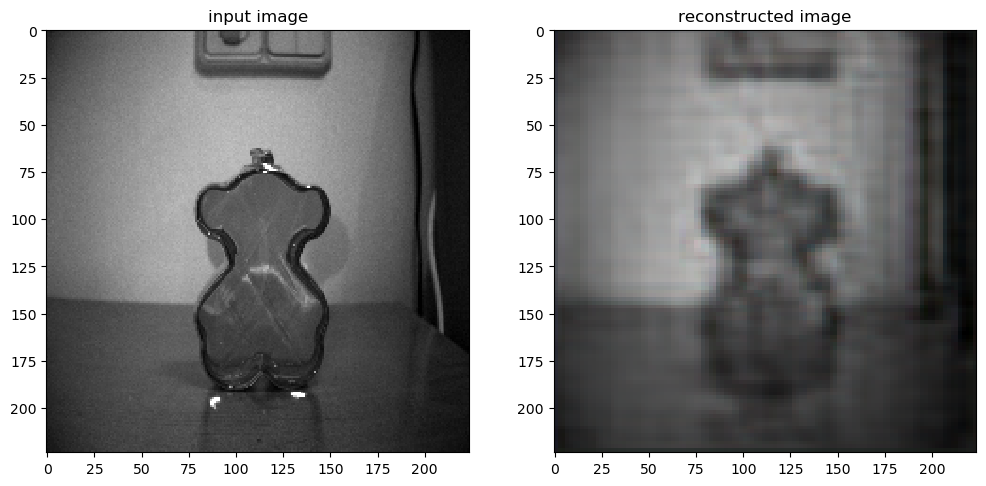

In [104]:
#Sanity check, view few images and corresponding reconstructions
image_number = 20
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("input image")
plt.imshow(data_batch_test[0][image_number])
plt.subplot(122)
plt.title("reconstructed image")
plt.imshow(predicted_fromTestSet[image_number])
plt.show()

Displaying the label of this particular image.

In [107]:
print(labels_test[0][image_number])

1.0
